In [1]:
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import optuna.integration.lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_path = 'train.csv'
test_path = 'test.csv'

In [3]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [4]:
train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [5]:
test.head()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,...,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,...,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,...,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,...,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,...,18,749,810,1773,15,8,7,1,0,1


In [24]:
x_imp=train.loc[:,['battery_power','px_height','px_width','ram']].values
y = train["price_range"].values


x_train,x_test,y_train,y_test = train_test_split(x_imp,y,test_size=0.3,random_state=1234)

<AxesSubplot:>

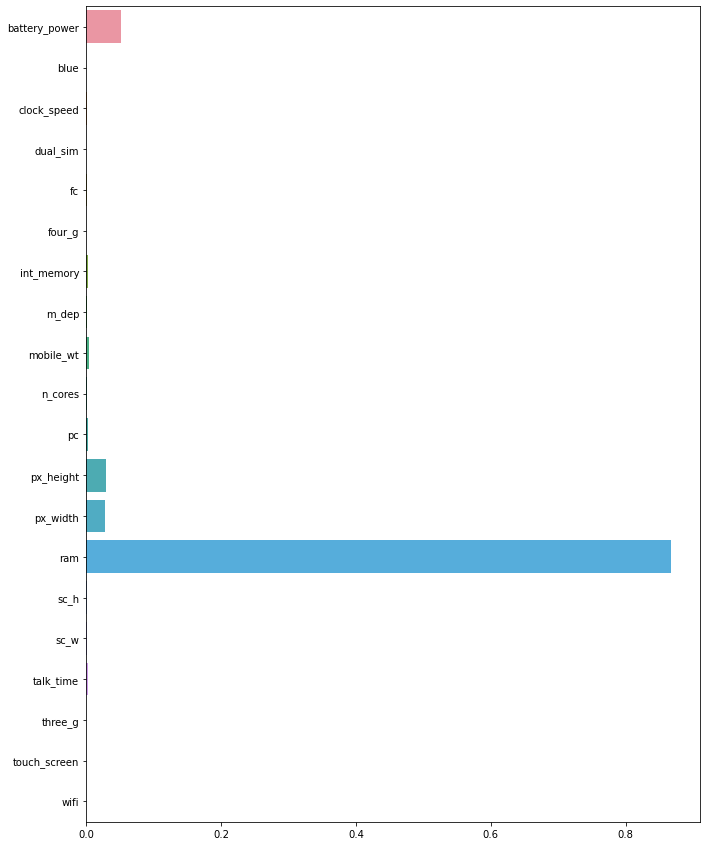

In [25]:
from sklearn.ensemble import RandomForestRegressor as RFR
rf = RFR(n_estimators=80, max_features='auto')
rf.fit(x, y)

f, ax = plt.subplots(figsize=(11, 15))
sns.barplot(x=rf.feature_importances_, y=train_data.columns.values, orient='h')

In [26]:
clf = RandomForestClassifier(n_estimators=100,random_state=1234)
clf.fit(x_train,y_train)

RandomForestClassifier(random_state=1234)

In [27]:
pred = clf.predict(x_test)

In [29]:
print('score=',clf.score(x_test,y_test))

score= 0.9166666666666666


In [30]:
#特徴量の標準化
x_train = (x_train - x_train.mean()) / x_train.std()
x_test = (x_test - x_test.mean()) / x_test.std()

In [31]:
from sklearn.model_selection import GridSearchCV
rfr_grid = GridSearchCV(clf,cv=5,param_grid = {'n_estimators':[10,25,50,100,],
              'min_samples_split':[0.5,2,4,10],
              'min_samples_leaf':[1,2,4,10],
              'max_features':[2,4,8],
              'bootstrap':[True, False]
              })
 
rfr_grid = rfr_grid.fit(x_train, y_train)
rfr_grid_best = rfr_grid.best_estimator_


KeyboardInterrupt: 

In [14]:
print("best params = ",rfr_grid.best_params_)

best params =  {'bootstrap': False, 'max_features': 8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [32]:
clf_best = RFR(n_estimators=100,
                max_features = 2,
                min_samples_split = 2,
                min_samples_leaf = 1,
                bootstrap = True,
                random_state = 1234)
clf_best.fit(x_train,y_train)
 

RandomForestRegressor(max_features=2, random_state=1234)

In [33]:
y_pred_cfr_best = clf_best.predict(x_test)

In [34]:
print('score=',clf_best.score(x_test,y_test))

score= 0.9434769527344137


In [51]:
#lgb
import lightgbm as lgb

model = lgb.LGBMClassifier(bootstrap=True)

In [36]:
model.fit(x_train,y_train)

[LightGBM] [Warning] Unknown parameter: bootstrap


LGBMClassifier(bootstrap=True)

In [37]:
pred = model.predict(x_test)

In [38]:
print('score=',model.score(x_test,y_test))

score= 0.89


In [39]:
# 目的関数の定義（最小値問題として定式化する。）
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
def objective(trial):
    min_samples_split = trial.suggest_int("min_samples_split", 8, 16)
    max_leaf_nodes = int(trial.suggest_discrete_uniform("max_leaf_nodes", 4, 64, 4))
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    
    RFC = RandomForestClassifier(min_samples_split = min_samples_split, 
                                max_leaf_nodes = max_leaf_nodes,
                                criterion = criterion)
    RFC.fit(x_train, y_train)
    return 1.0 - accuracy_score(y_test, RFC.predict(x_test))

In [40]:
#optuna
import optuna
study = optuna.create_study()
study.optimize(objective, n_trials = 100)

[I 2021-06-08 16:23:07,740] A new study created in memory with name: no-name-c6639161-b918-4de3-8f6a-fad974fd18c7
[I 2021-06-08 16:23:07,894] Trial 0 finished with value: 0.19999999999999996 and parameters: {'min_samples_split': 9, 'max_leaf_nodes': 8.0, 'criterion': 'entropy'}. Best is trial 0 with value: 0.19999999999999996.
[I 2021-06-08 16:23:08,037] Trial 1 finished with value: 0.10999999999999999 and parameters: {'min_samples_split': 15, 'max_leaf_nodes': 36.0, 'criterion': 'entropy'}. Best is trial 1 with value: 0.10999999999999999.
[I 2021-06-08 16:23:08,184] Trial 2 finished with value: 0.10666666666666669 and parameters: {'min_samples_split': 14, 'max_leaf_nodes': 64.0, 'criterion': 'entropy'}. Best is trial 2 with value: 0.10666666666666669.
[I 2021-06-08 16:23:08,311] Trial 3 finished with value: 0.09833333333333338 and parameters: {'min_samples_split': 15, 'max_leaf_nodes': 64.0, 'criterion': 'gini'}. Best is trial 3 with value: 0.09833333333333338.
[I 2021-06-08 16:23:08,

[I 2021-06-08 16:23:12,599] Trial 36 finished with value: 0.09833333333333338 and parameters: {'min_samples_split': 14, 'max_leaf_nodes': 60.0, 'criterion': 'entropy'}. Best is trial 3 with value: 0.09833333333333338.
[I 2021-06-08 16:23:12,748] Trial 37 finished with value: 0.09999999999999998 and parameters: {'min_samples_split': 15, 'max_leaf_nodes': 64.0, 'criterion': 'entropy'}. Best is trial 3 with value: 0.09833333333333338.
[I 2021-06-08 16:23:12,897] Trial 38 finished with value: 0.10166666666666668 and parameters: {'min_samples_split': 15, 'max_leaf_nodes': 64.0, 'criterion': 'entropy'}. Best is trial 3 with value: 0.09833333333333338.
[I 2021-06-08 16:23:13,052] Trial 39 finished with value: 0.10833333333333328 and parameters: {'min_samples_split': 16, 'max_leaf_nodes': 64.0, 'criterion': 'entropy'}. Best is trial 3 with value: 0.09833333333333338.
[I 2021-06-08 16:23:13,204] Trial 40 finished with value: 0.09833333333333338 and parameters: {'min_samples_split': 15, 'max_lea

[I 2021-06-08 16:23:17,990] Trial 72 finished with value: 0.09999999999999998 and parameters: {'min_samples_split': 15, 'max_leaf_nodes': 60.0, 'criterion': 'entropy'}. Best is trial 3 with value: 0.09833333333333338.
[I 2021-06-08 16:23:18,150] Trial 73 finished with value: 0.09833333333333338 and parameters: {'min_samples_split': 14, 'max_leaf_nodes': 56.0, 'criterion': 'entropy'}. Best is trial 3 with value: 0.09833333333333338.
[I 2021-06-08 16:23:18,295] Trial 74 finished with value: 0.10333333333333339 and parameters: {'min_samples_split': 14, 'max_leaf_nodes': 52.0, 'criterion': 'entropy'}. Best is trial 3 with value: 0.09833333333333338.
[I 2021-06-08 16:23:18,424] Trial 75 finished with value: 0.10166666666666668 and parameters: {'min_samples_split': 14, 'max_leaf_nodes': 60.0, 'criterion': 'gini'}. Best is trial 3 with value: 0.09833333333333338.
[I 2021-06-08 16:23:18,576] Trial 76 finished with value: 0.09499999999999997 and parameters: {'min_samples_split': 13, 'max_leaf_n

In [42]:
study.best_params    # 求めたハイパーパラメータ


{'min_samples_split': 13, 'max_leaf_nodes': 56.0, 'criterion': 'entropy'}

In [43]:
RFC = RandomForestClassifier(min_samples_split = 9, 
                                max_leaf_nodes = 44,
                                criterion = 'entropy')

In [46]:
RFC.fit(x_train,y_train)

RandomForestClassifier(criterion='entropy', max_leaf_nodes=44,
                       min_samples_split=9)

In [49]:
pred_op = RFC.predict(x_test)

In [50]:
print('score=',RFC.score(x_test,y_test))

score= 0.8916666666666667
